In [1]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# Caminho base dos CSVs
csv_dir = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/final_csv"

# Ler todos os arquivos CSV
csv_files = sorted(glob(os.path.join(csv_dir, "*.csv")))

In [4]:
# Lista de dataframes com o ano incluído
dfs = []
for f in csv_files:
    ano = int(os.path.basename(f).split("_")[2])  # extrai o ano
    df = pd.read_csv(f)
    df["ano"] = ano
    dfs.append(df)

# Unificar tudo em um dataframe só
df_all = pd.concat(dfs, ignore_index=True)

In [5]:
# municipios_alvo = ["Osório", "Imbé", "Tramandaí"]
# df_municipios = df_all[df_all["nm_mun"].isin(municipios_alvo)].copy()

df_municipios = df_all.copy()

In [6]:
# Soma da área por município, ano e tipo de cobertura
df_summary = (
    df_municipios.groupby(["ano", "nm_mun", "descricao"])["area_km2"]
    .sum()
    .reset_index()
)

In [7]:
# Novo diretório de salvamento
output_dir = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/graficos_mudanca_uso_do_solo_v1"

# Criar a pasta se não existir
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Definindo as cores padronizadas
cores_personalizadas = {
    "Campo Alagado e Área Pantanosa": "#519799",
    "Formação Campestre": "#d6bc74",
    "Mosaico de Usos": "#ffefc3",
    "Outras Lavouras Temporárias": "#f54ca9",
    "Outras Áreas não Vegetadas": "#db4d4f",
    "Pastagem": "#edde8e",
    "Praia, Duna e Areal": "#ffa07a",
    "Restinga Arbórea": "#02d659",
    "Restinga Herbácea": "#ad5100",
    "Rio, Lago e Oceano": "#2532e4",
    "Arroz": "#c71585",
    "Formação Florestal": "#1f8d49",
    "Silvicultura": "#7a5900",
    "Soja": "#f5b3c8",
    "Área Urbanizada": "#d4271e"  # <- importante: colocar por último no dicionário NÃO garante ordem no DataFrame
}

### Gráficos de barra, de mudança do uso do solo, por município (1985-2023)

In [9]:
# Lista de municípios
municipios = df_summary["nm_mun"].unique()

for municipio in municipios:
    # Filtra os dados do município
    df_m = df_summary[df_summary["nm_mun"] == municipio]
    pivot = df_m.pivot(index="ano", columns="descricao", values="area_km2").fillna(0)

    # Filtra apenas colunas com cor definida
    colunas_validas = [col for col in cores_personalizadas if col in pivot.columns]

    # Reorganiza as colunas para que "Área Urbanizada" fique por último (no topo da pilha)
    colunas_ordenadas = [col for col in colunas_validas if col != "Área Urbanizada"] + ["Área Urbanizada"]

    # Reordena o DataFrame
    pivot = pivot[colunas_ordenadas]

    # Define as cores na mesma ordem das colunas
    cores_plot = [cores_personalizadas[col] for col in pivot.columns]

    # Plot
    ax = pivot.plot(
        kind="bar", 
        stacked=True, 
        figsize=(12, 6),
        color=cores_plot
    )

    plt.title(f"Evolução da cobertura do solo - {municipio}")
    plt.ylabel("Área (km²)")
    plt.xlabel("Ano")
    plt.legend(title="Uso/Cobertura do Solo", bbox_to_anchor=(1.05, 1), loc='upper left')
    limite_superior = pivot.sum(axis=1).max() * 1.10
    plt.ylim(0, limite_superior)
    plt.tight_layout()

    # Adicionar percentual de área urbanizada
    if "Área Urbanizada" in pivot.columns:
        area_urbana = pivot["Área Urbanizada"]
        area_total = pivot.sum(axis=1)
        percentual = (area_urbana / area_total * 100).round(1)

        for i, (ano, pct) in enumerate(percentual.items()):
            ax.text(i, area_total[ano] + 1, f"{pct}%", ha="center", va="bottom", fontsize=9)

    # Caminho de salvamento
    output_path = os.path.join(output_dir, f"{municipio}_uso_solo.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


#### Salvar os percentuais em uma tabela csv

In [10]:
# Gerar tabela com percentuais de área urbanizada
dados_percentual = []

for municipio in municipios:
    df_m = df_summary[df_summary["nm_mun"] == municipio]
    pivot = df_m.pivot(index="ano", columns="descricao", values="area_km2").fillna(0)

    if "Área Urbanizada" in pivot.columns:
        total = pivot.sum(axis=1)
        pct_urb = (pivot["Área Urbanizada"] / total * 100).round(2)
        for ano, pct in pct_urb.items():
            dados_percentual.append({"nm_mun": municipio, "ano": ano, "pct_urb": pct})

# Salvar em CSV
df_pct = pd.DataFrame(dados_percentual)
df_pct.to_csv(os.path.join(output_dir, "percentual_urbanizado.csv"), index=False)


### Gráfico com a mudança de uso do solo para todo o Aulinor (1985-2023)

In [13]:
# Filtra e ordena colunas: "Área Urbanizada" por último para empilhamento no topo
colunas_validas = [col for col in cores_personalizadas if col in df_regiao_pivot.columns]
colunas_ordenadas = [col for col in colunas_validas if col != "Área Urbanizada"] + ["Área Urbanizada"]

# Reorganiza o DataFrame com essas colunas
df_regiao_pivot = df_regiao_pivot[colunas_ordenadas]

# Garante que as cores estejam na mesma ordem das colunas
cores_plot = [cores_personalizadas[col] for col in df_regiao_pivot.columns]

# Calcula a área total por ano (soma de todas as colunas)
total_por_ano = df_regiao_pivot.sum(axis=1)

# Obtém a série com os valores de "Área Urbanizada" por ano
area_urbana = df_regiao_pivot["Área Urbanizada"]
percentual_urbano = (area_urbana / total_por_ano) * 100

# Plotando o gráfico de barras empilhadas
ax = df_regiao_pivot.plot(kind="bar", stacked=True, figsize=(14, 7), color=cores_plot)

# Adicionando rótulos com o percentual de área urbanizada
for i, (ano, pct) in enumerate(percentual_urbano.items()):
    ax.text(
        i,                      # posição x
        total_por_ano.iloc[i] + 1,  # posição y, acima da barra empilhada
        f"{pct:.1f}%",          # texto
        ha='center', va='bottom',
        fontsize=10, color='black'
    )

# Finalização do gráfico
plt.title("Mudança no uso e cobertura do solo - Região AULINOR (1985–2023)")
plt.xlabel("Ano")
plt.ylabel("Área (km²)")
plt.legend(title="Uso/Cobertura do Solo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'df_regiao_pivot' is not defined

### Calcular, para cada município, o percentual de cada tipo de uso do solo original que foi substituído por área urbanizada até 2023

In [ ]:
# Carregar a planilha
arquivo = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_mapbiomas_expansao_urbana_1985-2023.xlsx"
df = pd.read_excel(arquivo)

# Garantir que a coluna de área esteja como número
df['area_km2'] = pd.to_numeric(df['area_km2'], errors='coerce')

# 1. Área total por município
area_total_mun = df.groupby('nm_mun', as_index=False)['area_km2'].sum()
area_total_mun.rename(columns={'area_km2': 'area_total_km2'}, inplace=True)

# 2. Percentual por 'descricao' dentro de cada município
area_por_desc = df.groupby(['nm_mun', 'descricao'], as_index=False)['area_km2'].sum()
# Juntar com total por município para calcular percentual
area_por_desc = area_por_desc.merge(area_total_mun, on='nm_mun')
area_por_desc['pct_mun'] = (area_por_desc['area_km2'] / area_por_desc['area_total_km2']) * 100

# 3. Salvar no mesmo arquivo Excel
with pd.ExcelWriter(arquivo, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    area_total_mun.to_excel(writer, sheet_name='area_total_por_mun', index=False)
    area_por_desc.to_excel(writer, sheet_name='percentual_por_desc', index=False)

### Arquivo excel unificado com area em km2 e percentual de area urbanizada por ano

In [17]:
import os
import pandas as pd
import glob

# Caminhos
pasta_csv = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/final_csv"
arquivo_area_total = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_munic_areamunic_total.xlsx"
saida_excel = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_area_urbanizada_por_municipio.xlsx"

# Lista arquivos CSV de cada ano
arquivos = glob.glob(os.path.join(pasta_csv, "aulinor_mapbiomas_*_pol.csv"))

# Lista para armazenar os DataFrames
dados = []

for arquivo in arquivos:
    ano = os.path.basename(arquivo).split('_')[2]
    df = pd.read_csv(arquivo)
    
    # Filtra apenas Área Urbanizada
    df_urb = df[df['descricao'] == 'Área Urbanizada'].copy()
    df_urb['ano'] = int(ano)
    
    dados.append(df_urb)

# Junta todos os anos
df_urb_todos = pd.concat(dados, ignore_index=True)

# Lê a área total dos municípios
df_area_total = pd.read_excel(arquivo_area_total)

# Renomeia a coluna para evitar conflitos
df_area_total.rename(columns={'area_km2': 'area_total_km2'}, inplace=True)

# Junta com os dados urbanizados
df_final = pd.merge(df_urb_todos, df_area_total, on='nm_mun', how='left')

# Calcula o percentual de área urbanizada
df_final['pct_area_urb_p_ano'] = (df_final['area_km2'] / df_final['area_total_km2']) * 100

# Seleciona as colunas finais
df_final = df_final[['nm_mun', 'ano', 'area_km2', 'pct_area_urb_p_ano']]

# Salva como Excel no caminho especificado
df_final.to_excel(saida_excel, index=False)

print("✅ Arquivo final salvo com sucesso em:\n", saida_excel)

✅ Arquivo final salvo com sucesso em:
 /Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_area_urbanizada_por_municipio.xlsx


#### Calcular o crescimento da área urbanizada entre 1985 e 2023

In [29]:
import os
import pandas as pd

# Caminho para o diretório onde estão os CSVs
pasta_csv = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/final_csv"

# Lê os arquivos de 1985 e 2023
arquivo_1985 = os.path.join(pasta_csv, "aulinor_mapbiomas_1985_pol.csv")
arquivo_2023 = os.path.join(pasta_csv, "aulinor_mapbiomas_2023_pol.csv")

df_1985 = pd.read_csv(arquivo_1985)
df_2023 = pd.read_csv(arquivo_2023)

# Filtra apenas "Área Urbanizada"
df_1985_urb = df_1985[df_1985['descricao'] == 'Área Urbanizada'][['nm_mun', 'area_km2']].copy()
df_2023_urb = df_2023[df_2023['descricao'] == 'Área Urbanizada'][['nm_mun', 'area_km2']].copy()

# Renomeia colunas para indicar o ano
df_1985_urb.rename(columns={'area_km2': 'area_km2_1985'}, inplace=True)
df_2023_urb.rename(columns={'area_km2': 'area_km2_2023'}, inplace=True)

# Junta os dois DataFrames
df_crescimento = pd.merge(df_1985_urb, df_2023_urb, on='nm_mun', how='outer').fillna(0)

# Calcula crescimento absoluto e percentual
df_crescimento['crescimento_km2'] = df_crescimento['area_km2_2023'] - df_crescimento['area_km2_1985']
df_crescimento['crescimento_percentual'] = df_crescimento.apply(
    lambda row: (row['crescimento_km2'] / row['area_km2_1985'] * 100) if row['area_km2_1985'] > 0 else float('inf'),
    axis=1
)

# Define o caminho de saída
caminho_saida = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_munic_cresc_areaurb_1985-2023.xlsx"

# Salva o resultado
df_crescimento.to_excel(caminho_saida, index=False)

print("Arquivo de crescimento salvo com sucesso!")

Arquivo de crescimento salvo com sucesso!


### Criar matriz de total de área urbanizada por municipio por ano

In [30]:
import pandas as pd
import os

# Caminho do arquivo original
caminho_entrada = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_area_urbanizada_por_municipio.xlsx"

# Caminho do novo arquivo
caminho_saida = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_area_urbanizada_por_municipio_matriz.xlsx"

# Lê o arquivo Excel
df = pd.read_excel(caminho_entrada)

# Cria colunas combinando ano com os nomes
df['col_km2'] = df['ano'].astype(str) + "_km2"
df['col_pct'] = df['ano'].astype(str) + "_pct"

# Cria dois dataframes separados para km2 e pct
df_km2 = df.pivot(index='nm_mun', columns='col_km2', values='area_km2')
df_pct = df.pivot(index='nm_mun', columns='col_pct', values='pct_area_urb_p_ano')

# Junta os dois
df_final = pd.concat([df_km2, df_pct], axis=1)

# Ordena as colunas pelos anos corretamente
anos = ['1985', '1990', '1995', '2000', '2005', '2010', '2015', '2020', '2023']
colunas_ordenadas = []
for ano in anos:
    colunas_ordenadas.append(f"{ano}_km2")
    colunas_ordenadas.append(f"{ano}_pct")

# Garante que existam apenas colunas válidas (no caso de anos ausentes nos dados)
colunas_existentes = [col for col in colunas_ordenadas if col in df_final.columns]
df_final = df_final[colunas_existentes]

# Salva em Excel
df_final.reset_index().to_excel(caminho_saida, index=False)

print("Arquivo salvo com sucesso em formato de matriz.")

Arquivo salvo com sucesso em formato de matriz.


#### Criar gráfico de linhas

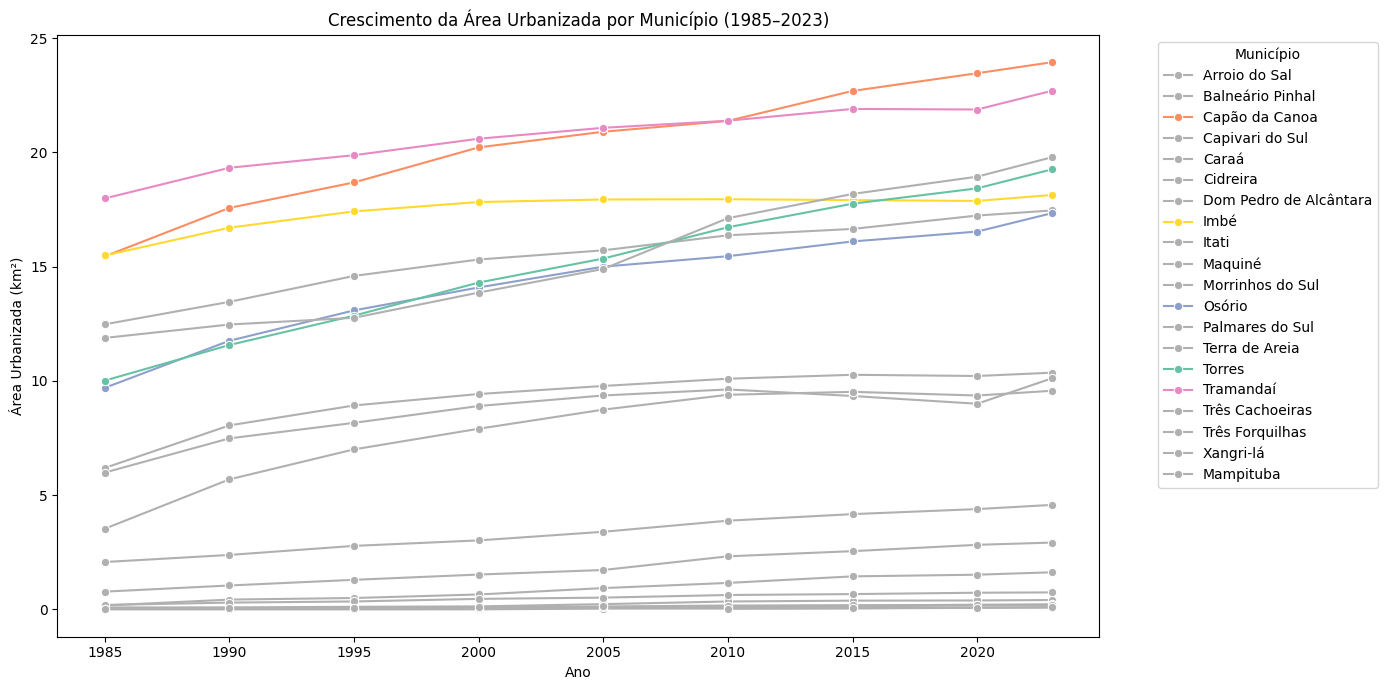

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lê os dados
caminho_excel = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_area_urbanizada_por_municipio.xlsx"
df = pd.read_excel(caminho_excel)

# Lista de municípios para destacar com cores
municipios_destaque = ['Torres', 'Capão da Canoa', 'Osório', 'Tramandaí', 'Xangri-Lá', 'Imbé']

# Lista única de todos os municípios
todos_municipios = df['nm_mun'].unique()

# Mapeamento de cores: cinza para todos, cores fortes para os destaques
cores = {}
palette_colorida = sns.color_palette("Set2", n_colors=len(municipios_destaque))
for mun in todos_municipios:
    if mun in municipios_destaque:
        cores[mun] = palette_colorida[municipios_destaque.index(mun)]
    else:
        cores[mun] = "#B0B0B0"  # tom de cinza

# Plotando
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df,
    x="ano",
    y="area_km2",
    hue="nm_mun",
    palette=cores,
    marker="o"
)

# Estilização
plt.title("Crescimento da Área Urbanizada por Município (1985–2023)")
plt.xlabel("Ano")
plt.ylabel("Área Urbanizada (km²)")
plt.legend(title="Município", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostra o gráfico
plt.show()

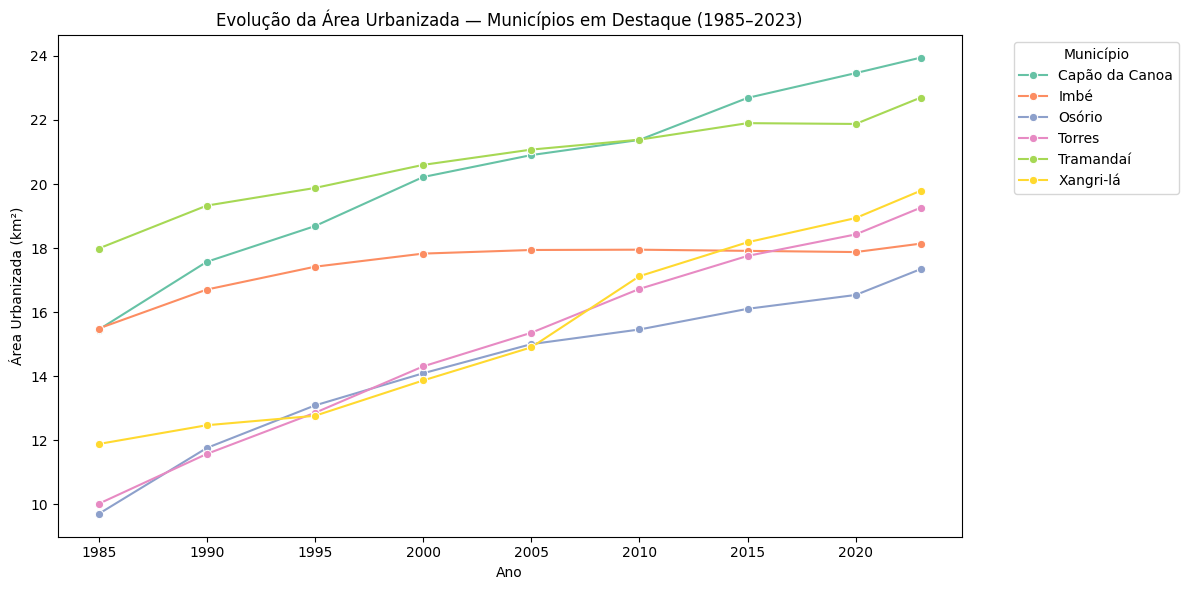

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lê os dados
caminho_excel = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_area_urbanizada_por_municipio.xlsx"
df = pd.read_excel(caminho_excel)

# Lista de municípios a destacar
municipios_destaque = ['Torres', 'Capão da Canoa', 'Osório', 'Tramandaí', 'Xangri-lá', 'Imbé']

# Filtra apenas os municípios desejados
df_filtrado = df[df['nm_mun'].isin(municipios_destaque)].copy()

# Cria gráfico com paleta colorida apenas para os destacados
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_filtrado,
    x="ano",
    y="area_km2",
    hue="nm_mun",
    marker="o",
    palette="Set2"
)

# Estilização
plt.title("Evolução da Área Urbanizada — Municípios em Destaque (1985–2023)")
plt.xlabel("Ano")
plt.ylabel("Área Urbanizada (km²)")
plt.legend(title="Município", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostra o gráfico
plt.show()

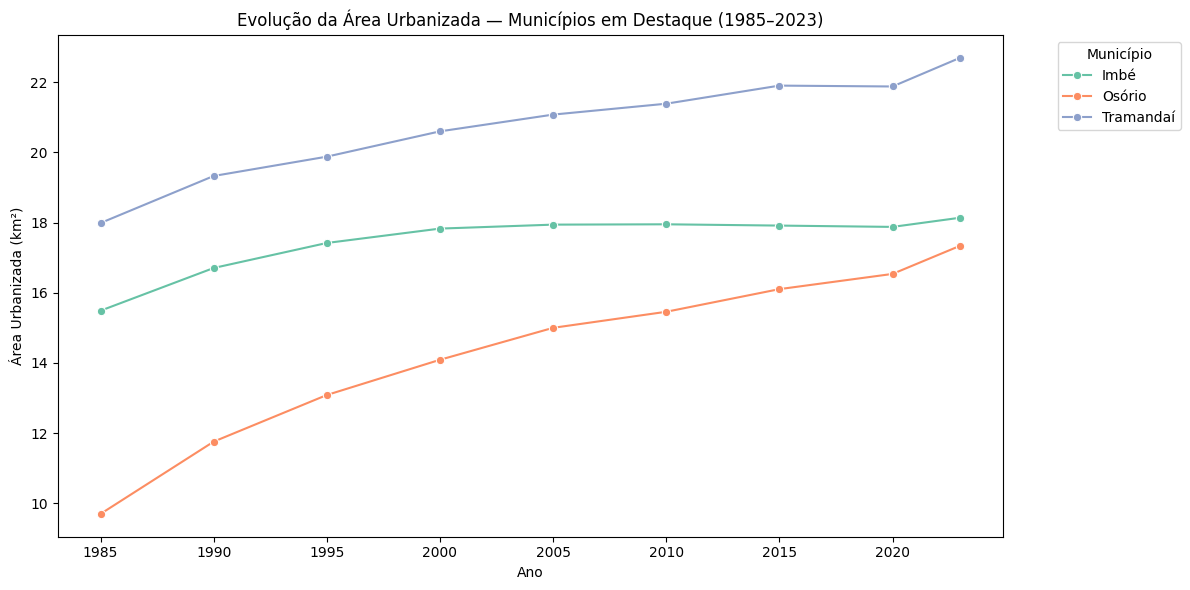

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lê os dados
caminho_excel = "/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_area_urbanizada_por_municipio.xlsx"
df = pd.read_excel(caminho_excel)

# Lista de municípios a destacar
municipios_destaque = ['Osório', 'Tramandaí', 'Imbé']

# Filtra apenas os municípios desejados
df_filtrado = df[df['nm_mun'].isin(municipios_destaque)].copy()

# Cria gráfico com paleta colorida apenas para os destacados
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_filtrado,
    x="ano",
    y="area_km2",
    hue="nm_mun",
    marker="o",
    palette="Set2"
)

# Estilização
plt.title("Evolução da Área Urbanizada — Municípios em Destaque (1985–2023)")
plt.xlabel("Ano")
plt.ylabel("Área Urbanizada (km²)")
plt.legend(title="Município", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostra o gráfico
plt.show()

In [2]:
import pandas as pd
import os

# Caminho do arquivo original
input_path = '/Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/aulinor_mapbiomas_desmatamento_1985-2023_areaurbanizada2023.xlsx'

# Leitura do arquivo Excel
df = pd.read_excel(input_path)

# Mapeamento para colunas desejadas
mapa_colunas = {
    ('Dentro da área urbanizada de 2023', 'Supressão de Vegetação Primária'): 'dentro_veg_prim',
    ('Fora da área urbanizada de 2023', 'Supressão de Vegetação Primária'): 'fora_veg_prim',
    ('Dentro da área urbanizada de 2023', 'Supressão de Vegetação Secundária'): 'dentro_veg_sec',
    ('Fora da área urbanizada de 2023', 'Supressão de Vegetação Secundária'): 'fora_veg_sec'
}

# Criação das novas colunas com valores agregados
df['coluna_temp'] = df.apply(lambda row: mapa_colunas.get((row['tipo'], row['descricao'])), axis=1)
df_agg = df.pivot_table(index='nm_mun', 
                        columns='coluna_temp', 
                        values='area_km2', 
                        aggfunc='sum').reset_index()

# Garante que todas as colunas esperadas estão presentes
for col in ['dentro_veg_prim', 'fora_veg_prim', 'dentro_veg_sec', 'fora_veg_sec']:
    if col not in df_agg.columns:
        df_agg[col] = 0

# Reordenando colunas
df_agg = df_agg[['nm_mun', 'dentro_veg_prim', 'fora_veg_prim', 'dentro_veg_sec', 'fora_veg_sec']]

# Salvando no mesmo diretório
output_path = os.path.join(
    os.path.dirname(input_path),
    'tabela_agrupada_desmatamento.xlsx'
)
df_agg.to_excel(output_path, index=False)

print(f"Tabela salva em: {output_path}")

Tabela salva em: /Users/lina/Library/CloudStorage/GoogleDrive-faccincarolina@gmail.com/Meu Drive/Qgis/shapefiles/rs_aulinor/mapbiomas/tabela_agrupada_desmatamento.xlsx
